## Imports

In [36]:
import numpy as np
from pydub import AudioSegment
import glob
from scipy.io import wavfile
from scipy.io import loadmat
from keras.utils import to_categorical
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Loading Files

In [4]:
def load_files(folder_path):
    """
    Input: folder_path: location of the files on local drive (string)
    Output: df: the data in Pandas dataframe format 
    Output: files: the data in python dictionary format
    """
    files = []
    wav_files = glob.glob(folder_path + "/*.wav")
    for wav_file in wav_files:
        file_dic = {}
        file_dic['wav_file'] = wav_file
        sr, data = wavfile.read(wav_file)        
        file_dic['sr'] = sr
        mat = loadmat(wav_file + ".not.mat")
        try:
            labels = mat['labels'][0]
            onsets = mat['onsets']
            offsets = mat['offsets']
        except:
            continue
        file_dic['notes'] = []
        for i in range(len(labels)):
            not_data = {}
            not_data['label'] = labels[i]
            not_data['onset'] = onsets[i][0] - onsets[0][0]
            not_data['offset'] = offsets[i][0] - onsets[0][0]
            file_dic['notes'].append(not_data)
        first_label_start = int(onsets[0][0] / 1000 * sr)
        last_label_end = int(offsets[i][0] / 1000 * sr)
        # Cropping the two ends
        cropped_aud = data[first_label_start:last_label_end]
        file_dic['audio'] = cropped_aud
        file_dic['dur'] = len(cropped_aud)
        file_dic['dur_ms'] = int(len(cropped_aud)/sr*1000)
        files.append(file_dic)
    df = pd.DataFrame(files)
    return df, files

In [5]:
# Loading the files
df, files = load_files("./songs")

## Preprocessing

In [7]:
# The sampling rate for all the wav files is 44100 Hz
sr = 44100
# max length in ms
max_dur_ms = df['dur_ms'].max() 
max_dur = df['dur'].max()

In [8]:
aud = files[1]['audio']
aud.shape

(455072,)

In [9]:
# Used to standardize volume of audio clip
# def match_target_amplitude(sound, target_dBFS):
#     change_in_dBFS = target_dBFS - sound.dBFS
#     return sound.apply_gain(change_in_dBFS)

# aud_standard = match_target_amplitude(aud, -20.0)

In [13]:
# Zero Padding and Converting one raw audio vector to spectrogram

def make_x(audio):
    nfft = 200 # Length of each window segment
    fs = 8000 # Sampling frequencies
    noverlap = 120 # Overlap between windows
    audio_dur = len(audio)
    pad_len = max_dur - audio_dur
    padded_audio = np.pad(audio, (0,pad_len),'constant')
    x, _, _, _ = plt.specgram(padded_audio, nfft, fs, noverlap = noverlap, sides='onesided', mode='psd')
    return np.transpose(x)

(6703, 101)

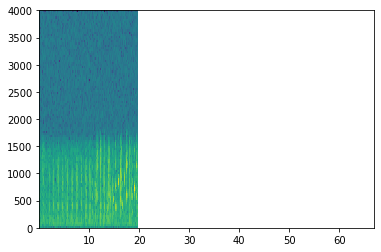

In [15]:
aud = files[11]['audio']
x = make_x(aud)
x.shape

In [17]:
# Processing the labels and finding the number of classes. These will be used later.
y_labels = set()
for file in files:
    for note in file['notes']:
        y_labels.add(note['label'])
y_lab_to_int = {lab: i+1 for i,lab in enumerate(y_labels)}
y_lab_to_int['!'] = 0 # Label for background
y_int_to_lab = {ind: lab for lab,ind in y_lab_to_int.items()}
num_classes = len(y_labels) + 1

In [18]:
# y_int_to_lab
# y_lab_to_int
# y_labels
num_classes

20

49 666 6703 101
Example of an spectrogram. The right portion is the padded area.


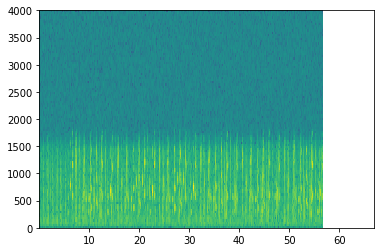

In [19]:
# m is the number of training examples
m = len(files)

# Shape of one training input x
Tx,n_freqs = make_x(files[1]['audio']).shape

# RNN's first layer Paramaters:
fsize= 50 # filter size
s = 10 # stride
# Ty is the number of labels in Y. This can be changed by modifying the RNN architecture
Ty = int((Tx - fsize)/s + 1)
print(m, Ty, Tx, n_freqs)
print('Example of an spectrogram. The right portion is the padded area.')

In [23]:
def insert_labels(file):
    """
    input: file: one item of the files dictionary that contains the labels and their position in milliseconds.
    output: y: one y vector in one hot format.
    """
    y = np.zeros((1,Ty))
    notes = file['notes']
    for note in notes:
        label = y_lab_to_int[note['label']]
        onset = int(note['onset'])
        offset = int(note['offset'])
        segment_start_y = int(onset * Ty / max_dur_ms)
        segment_end_y = int(offset * Ty / max_dur_ms)
        for ty in range(segment_start_y, segment_end_y):
            y[0,ty] = label
    
    y = to_categorical(y,num_classes=num_classes)
    return y

## Putting together X and Y

(49, 6703, 101)
(49, 666, 20)


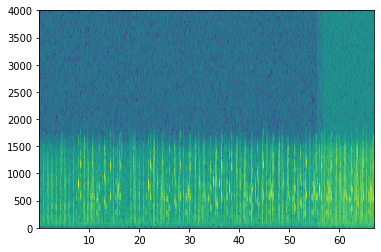

In [24]:
# Initializing the X and Y with the right dimensions.
X = np.zeros((m,Tx,n_freqs))
Y = np.zeros((m,Ty, num_classes))

for i in range(m):
    X[i,:,:] = make_x(files[i]['audio'])
    Y[i,:,:] = insert_labels(files[i])

print(X.shape)
print(Y.shape)

In [25]:
parameters = {'num_classes': num_classes, 'fsize': fsize, 'stride': s, 'Tx': Tx, 'Ty': Ty, 'nfreqs': n_freqs}
parameters

{'num_classes': 20,
 'fsize': 50,
 'stride': 10,
 'Tx': 6703,
 'Ty': 666,
 'nfreqs': 101}

In [105]:
import pickle
x_pickle = pickle.dump(X, open("x_pickle.p", "wb"))
y_pickle = pickle.dump(Y, open("y_pickle.p", "wb"))
par_pickle = pickle.dump(parameters, open('par_pickle.p', 'wb'))

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Building the RNN in Keras

In [27]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam

In [28]:
def model(input_shape):
    X_input = Input(shape = input_shape)

    X = Conv1D(filters=196,kernel_size=fsize,strides=s)(X_input)    # CONV1D
    X = BatchNormalization()(X)                                 # Batch normalization
    X = Activation('relu')(X)                                 # ReLu activation
    X = Dropout(rate=0.2)(X)                                 # dropout

    X = Bidirectional(LSTM(units=128, return_sequences=True))(X) # Bidirectional LSTM
    X = Dropout(rate=0.2)(X)                                 # dropout
    X = BatchNormalization()(X)                                 # Batch normalization
    
    X = Bidirectional(LSTM(units=128, return_sequences=True))(X) # Bidirectional LSTM
    X = Dropout(rate=0.2)(X)                                 # dropout
    X = BatchNormalization()(X)                                 # Batch normalization
    X = Dropout(rate=0.2)(X)                                 # dropout
    
    X = TimeDistributed(Dense(num_classes, activation='softmax'))(X) # time distributed

    model = Model(inputs = X_input, outputs = X)
    
    return model  

In [29]:
model = model(input_shape = (Tx, n_freqs))

In [30]:
model.summary()

In [31]:
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])

In [32]:
model.fit(X_train, y_train, batch_size = 5, epochs=20)

Epoch 1/20
39/39 [==============================] - 29s 754ms/step - loss: 3.3202 - accuracy: 0.2988
Epoch 2/20
39/39 [==============================] - 25s 641ms/step - loss: 2.7487 - accuracy: 0.5231
Epoch 3/20
39/39 [==============================] - 26s 667ms/step - loss: 2.5017 - accuracy: 0.5363
Epoch 4/20
39/39 [==============================] - 25s 641ms/step - loss: 2.3494 - accuracy: 0.5844
Epoch 5/20
39/39 [==============================] - 25s 649ms/step - loss: 2.2156 - accuracy: 0.6216
Epoch 6/20
39/39 [==============================] - 25s 630ms/step - loss: 2.1531 - accuracy: 0.6408
Epoch 7/20
39/39 [==============================] - 25s 636ms/step - loss: 2.0260 - accuracy: 0.6734
Epoch 8/20
39/39 [==============================] - 25s 638ms/step - loss: 1.9858 - accuracy: 0.6804
Epoch 9/20
39/39 [==============================] - 25s 638ms/step - loss: 1.9512 - accuracy: 0.6855
Epoch 10/20
39/39 [==============================] - 25s 633ms/step - loss: 1.8795 - accura

In [33]:
# Testing with model with the test set
loss, acc = model.evaluate(X_test, y_test)
print("Test set accuracy = ", acc)

10/10 [==============================] - 2s 219ms/step
Test set accuracy =  0.767717719078064


In [104]:
# Saving the model
model.save('model_RNN.h5')

## Making Predictions

In [54]:
from keras.models import load_model
# load model
model = load_model('model_RNN.h5')
# summarize model.
# model.summary()

In [55]:
def detect_syllables(wav_file):
    sr, data = wavfile.read(wav_file)
    x = make_x(data)
    # the spectrogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    return predictions

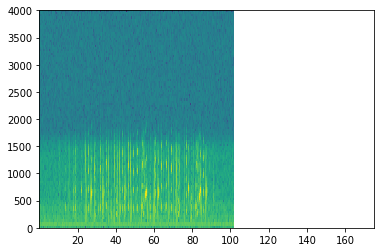

In [57]:
pred_file = files[1]['wav_file']
pred_file
pred = detect_syllables(pred_file)

In [35]:
# Printing the labels in a list. Each element in the list represents a unit of time equal to max_len_ms/Ty
labels_list = [y_int_to_lab[np.argmax(pred[:,i,:])] for i in range(pred.shape[1])]
print(labels_list)